![project presentation slide](images/slides/Slide2.jpeg)

## __CONTENT__
---

### __In this notebook, we will explore [Clafornia Housing Prices Dataset from Kaggle](https://www.kaggle.com/camnugent/california-housing-prices), and we will select features, that can be used as good predictors for house prices, in PriceHook app.__

__REQUIREMENTS FOR SELECTED FEATURES__
* Each of the selected features must be also either avaiable with goodle search, or these must be features that are easy to verify, by the visitor/home owner, such as number of rooms, parking spaces in garage, neighbourhood etc.... 
* in the future many of the selected features should be able to estimated with deep learning analysis, by classyfying pictures taken with the phone,  

__TOOLS USED IN THIS TASK__  
For, this task I will use, my package called DataFrame explorer, that was created to summarize, explore and clean small and medium size datasets with large number of features and mixed data types__

![project presentation slide](images/title_images/figure_examples.png)

In [1]:
import os
import sys
import re
import glob
import random
import itertools

import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats

from matplotlib import colors
from itertools import combinations
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.pipeline import Pipeline 
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

In [2]:
# set basedir
basedir = os.getcwd()
os.chdir(basedir)

In [3]:
# my tools
from src.utils import DataFrameExplorer_summary as dfe # to explore data in df, 
from src.utils import Pawel_Rosikiewicz_house_prices_helpers as fs
from src.utils.DataFrameExplorer_duplicates import calculate_si
from src.utils.DataFrameExplorer_duplicates import si_heatmap
from src.utils.DataFrameExplorer_duplicates import order_si_table
from src.utils.plot_histograms import plot_histograms
from src.utils.plot_scatter import test_outlier_removal_with_zscore
from src.utils.plot_heatmaps import corr_heatmap
from src.utils.plot_heatmaps import table_with_sorted_corr_results
from src.utils.pca_helpers import plot_pca_resutls
from src.utils.plot_boxplots import ordered_boxplots

# configs
from src.configs.dfe_configs import df_summary_plot__pieChart_dct
from src.configs.dfe_configs import df_summary_plot__barPlot_dct
from src.configs.dataset_configs import CONTINUOUS_FEATURES # list
from src.configs.dataset_configs import ORDINAL_VARIABLES_WITH_VALUES # dict, key: variable name, value: list. with class names 

## LOAD & PREPARE THE DATA
Fist, download [Clafornia Housing Prices](https://www.kaggle.com/camnugent/california-housing-prices), from kaggle into /data/raw

In [4]:
# Load to DataFrame
data = pd.read_csv(os.path.join(basedir,'data/raw/house-prices.csv'))
print(data.shape)
data.head()

(2430, 82)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,484,528275070,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,236000
1,2586,535305120,20,RL,75.0,10170,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,155000
2,2289,923228250,160,RM,21.0,2001,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,75000
3,142,535152150,20,RL,70.0,10552,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,165500
4,2042,903475060,190,RM,60.0,10120,Pave,NaN,IR1,Bnk,...,0,NaN,MnPrv,NaN,0,1,2007,WD,Normal,122000


#### Prepare the data for exploration and remove two columns with ID and order

In [5]:
# Create X,y
X = data.drop('SalePrice', axis=1)
y = data.SalePrice 

# remove selected columns from X,
'''these only duplicate index number'''
X = X.drop(['Order', 'PID'], axis=1) 

# Split data into model/validation sets
X_model, X_validation, y_model, y_validation = train_test_split(
    X, y, 
    test_size=0.15, 
    random_state=0 # fixed and used in notebooks 2 & 3
)

# test shape 
print('(Train/Test):', X_model.shape, y_model.shape)
print('Validation:', X_validation.shape, y_validation.shape)

(Train/Test): (2065, 79) (2065,)
Validation: (365, 79) (365,)


## Create Dataset Summary
---

__MAIN QUESTIONS__
* what is the number of numeric, and text features?
* what is the range or class number in each feature?
* what is the amount and distribusion of missing data?
* are all features balanced?
* get examples of each feature, and their distribusion
* __missing data__
    * how much of missing data is there, 
    * what is the distribusion of missing data



__GENERAL OBSERVATIONS__   
* all features were either numeric or text (see pie chart), howver, from the documentation at kaggle, we know that some of text variables are indicator variables, that were listed with their values in src/configs/dataset_configs.py 
* majority of features have no missing data (barcharts 1 and 2)
* great majority of features, especially categorical, are imbalanced - one class has large proportion of all instances in the data.

__ACTIONS & RECOMENDATIONS__  
* remove 'Order', and 'Observation number' columns - these only duplicate index number
* columns with >80% of NaN, could be replicaced with binary feature, present-absent
* replace NaN in FireplaceQu with No Fireplace at 41% of instances. 

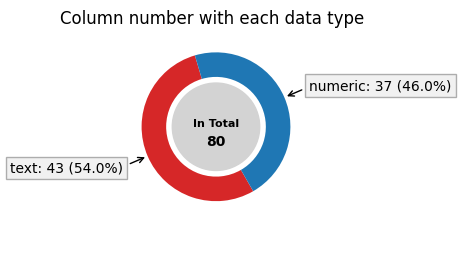

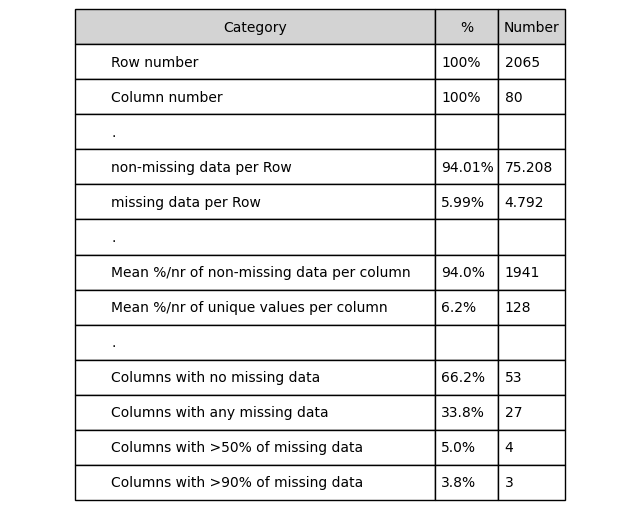

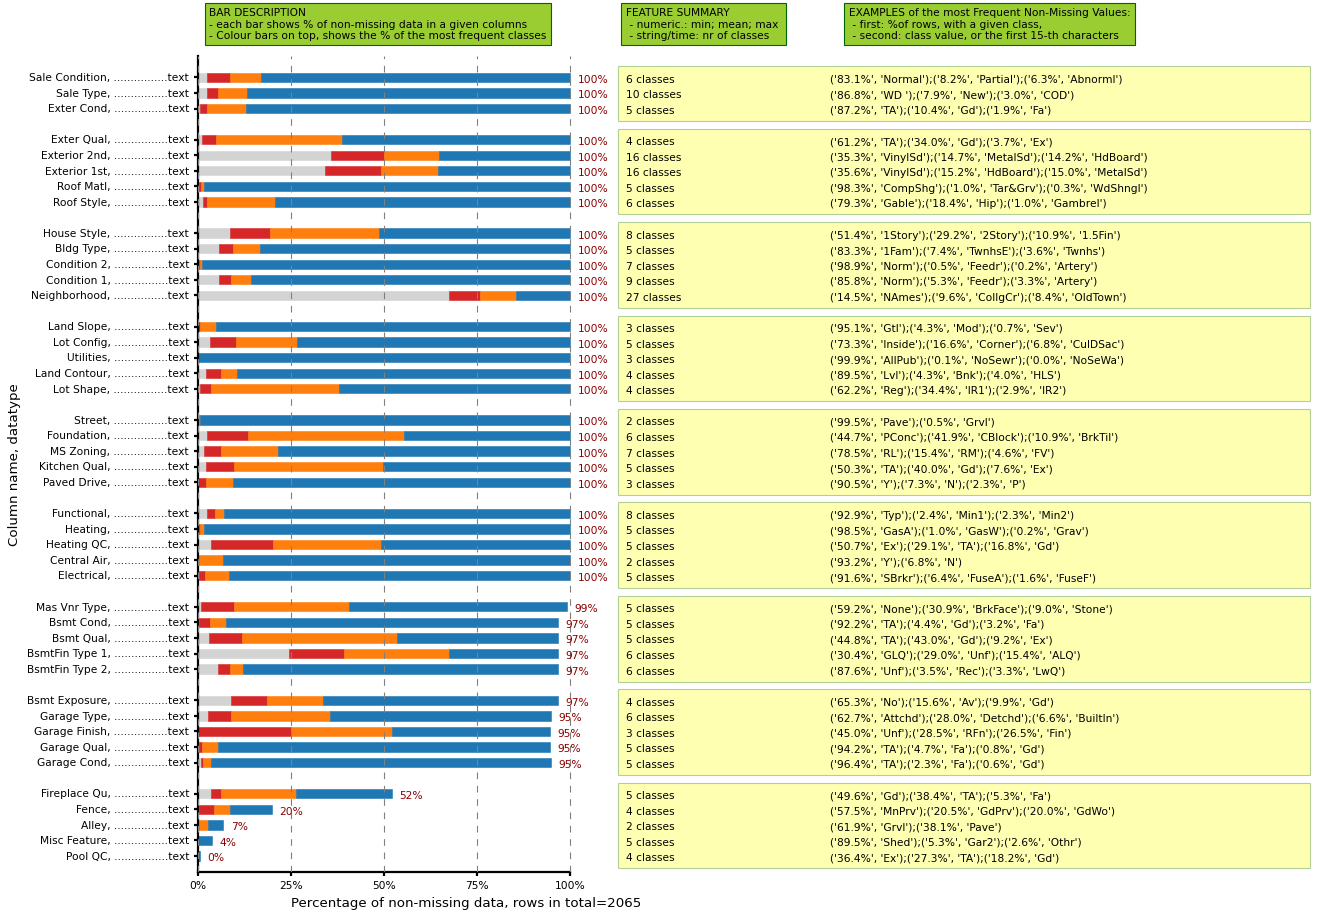

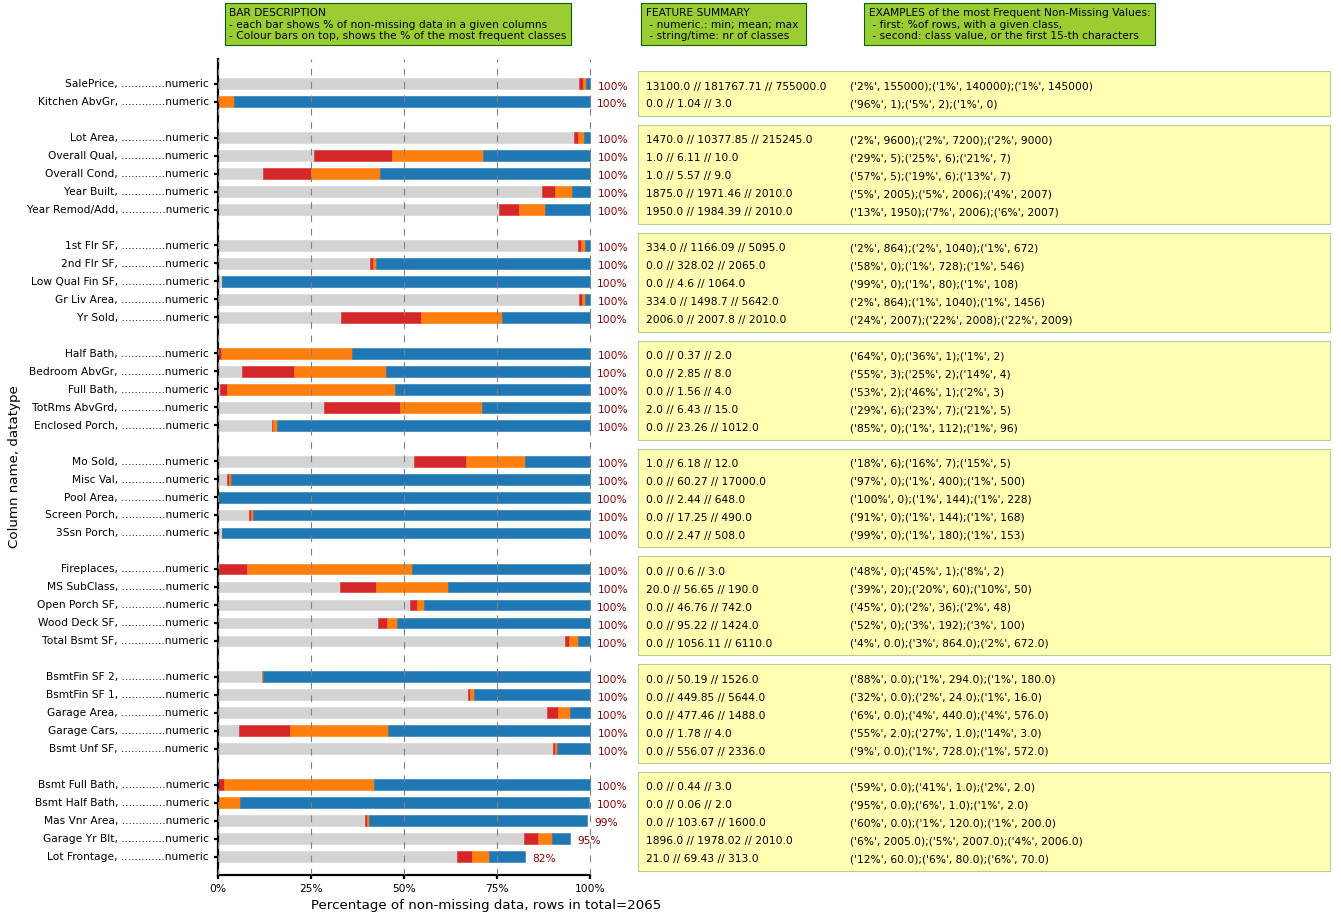

In [6]:
""" Tips:
        * use help(dfe.df_summary_plot)
        * double click on figure to enlarge
"""
# get examples from each feature
data_df = pd.concat([X_model, y_model], axis=1)

# plot data frame summary with dfe package
dfe.df_summary_plot(
    df                  = data_df,
    barPlot_figsize     = (18,12),
    groups_to_display   = ['text','numeric','datetime'], 
                          # each group will have separate suplot, for better readability
    barPlot_dct         = df_summary_plot__barPlot_dct, # dict with configs
    pieChart_dct        = df_summary_plot__pieChart_dct # dict with configs
) 

## __EXAMINE NUMERICAL VARIABLES IN MORE DETAIL__
---

List of coninuous numerical variables, ie. not indicating classes can be fund in data documentation.txt/.csv   
I added names of these variables into CONTINUOUS_FEATURES list,  

__METHODS__
* I examined continuous numerical Variables & tested potential transformations that could de applied automatically
* I used scatterplots & boxplots to see whther I can observe outliers in each features, 
* I also tested if I can easily remove ouliers from scaled data, using z-score, and what threshold should be used, 

In [7]:
# check dtype, and calulate the mean for listed features, 
'''done just to check if my list wiht numerical variables is correct'''
fs.get_df_dtypes(df=data_df.loc[:,CONTINUOUS_FEATURES])

0, Lot Frontage, dtpye = float64, mean=69.42781690140845
1, Lot Area, dtpye = int64, mean=10377.849394673123
2, Mas Vnr Area, dtpye = float64, mean=103.6730112249878
3, BsmtFin SF 1, dtpye = float64, mean=449.8512596899225
4, BsmtFin SF 2, dtpye = float64, mean=50.189437984496124
5, Bsmt Unf SF, dtpye = float64, mean=556.0726744186046
6, Total Bsmt SF, dtpye = float64, mean=1056.1133720930231
7, 1st Flr SF, dtpye = int64, mean=1166.0866828087167
8, 2nd Flr SF, dtpye = int64, mean=328.018401937046
9, Low Qual Fin SF, dtpye = int64, mean=4.599031476997578
10, Gr Liv Area, dtpye = int64, mean=1498.7041162227604
11, Garage Area, dtpye = float64, mean=477.4573643410853
12, Wood Deck SF, dtpye = int64, mean=95.2232445520581
13, Open Porch SF, dtpye = int64, mean=46.75786924939467
14, Enclosed Porch, dtpye = int64, mean=23.255690072639226
15, 3Ssn Porch, dtpye = int64, mean=2.468765133171913
16, Screen Porch, dtpye = int64, mean=17.246973365617432
17, Pool Area, dtpye = int64, mean=2.43825665

### __TEST DIFFERENT SCALING METHODS__
I used only a subset of features, to make small, and clear figures. you may produce plots for all numerical features with s_features = CONTINUOUS_FEATURES

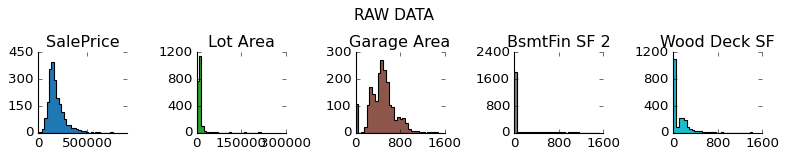

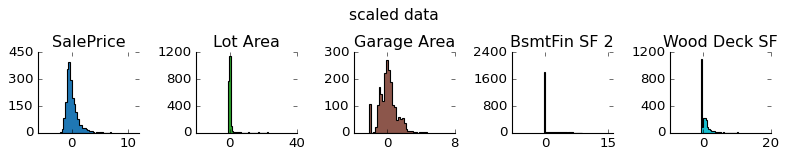

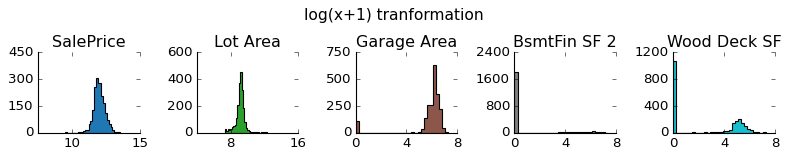

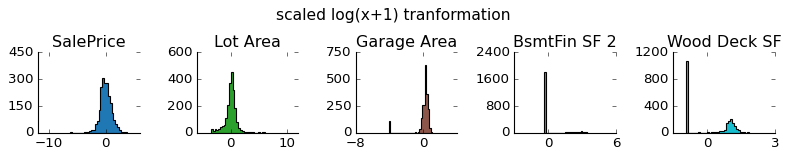

In [8]:
# subset some of numerical features
s_features = ["SalePrice",'Lot Area','Garage Area', 'BsmtFin SF 2','Wood Deck SF']
s_df = data_df.loc[:,s_features]

# plot hist with raw data , and different types of tranformations
plot_histograms(title="RAW DATA", df=s_df, names=s_features)
plot_histograms(title="scaled data", df=scale(s_df), names=s_features)
plot_histograms(title="log(x+1) tranformation", df=np.log1p(s_df), names=s_features)
plot_histograms(title="scaled log(x+1) tranformation", df=scale(np.log1p(s_df)), names=s_features)

### __VISUALIZE POTENTIAL OUTLIERS__
From the histograms, we know that some of numerical features may have outliers, that may be either removed, trimmed to min/max values, or replaced. For this reason, we will use modified scatter-plot to visualize these potential outliers, and their number in each numerical variable. 

Each scatterplot shows, one numerical variable from the dataset, with its raw values on y-axis, and log1p values on x-axis. The red line represents the mean, and dashed lines shows potential filtering threshold, caulated with z score (function parameter). 
My function adds random noise to points on both x,y axes, to allow visualizations of multiple points with the same values, eg: many points can be equal to 0, and thus woudl be represented as one point on a "standard" scattrplot

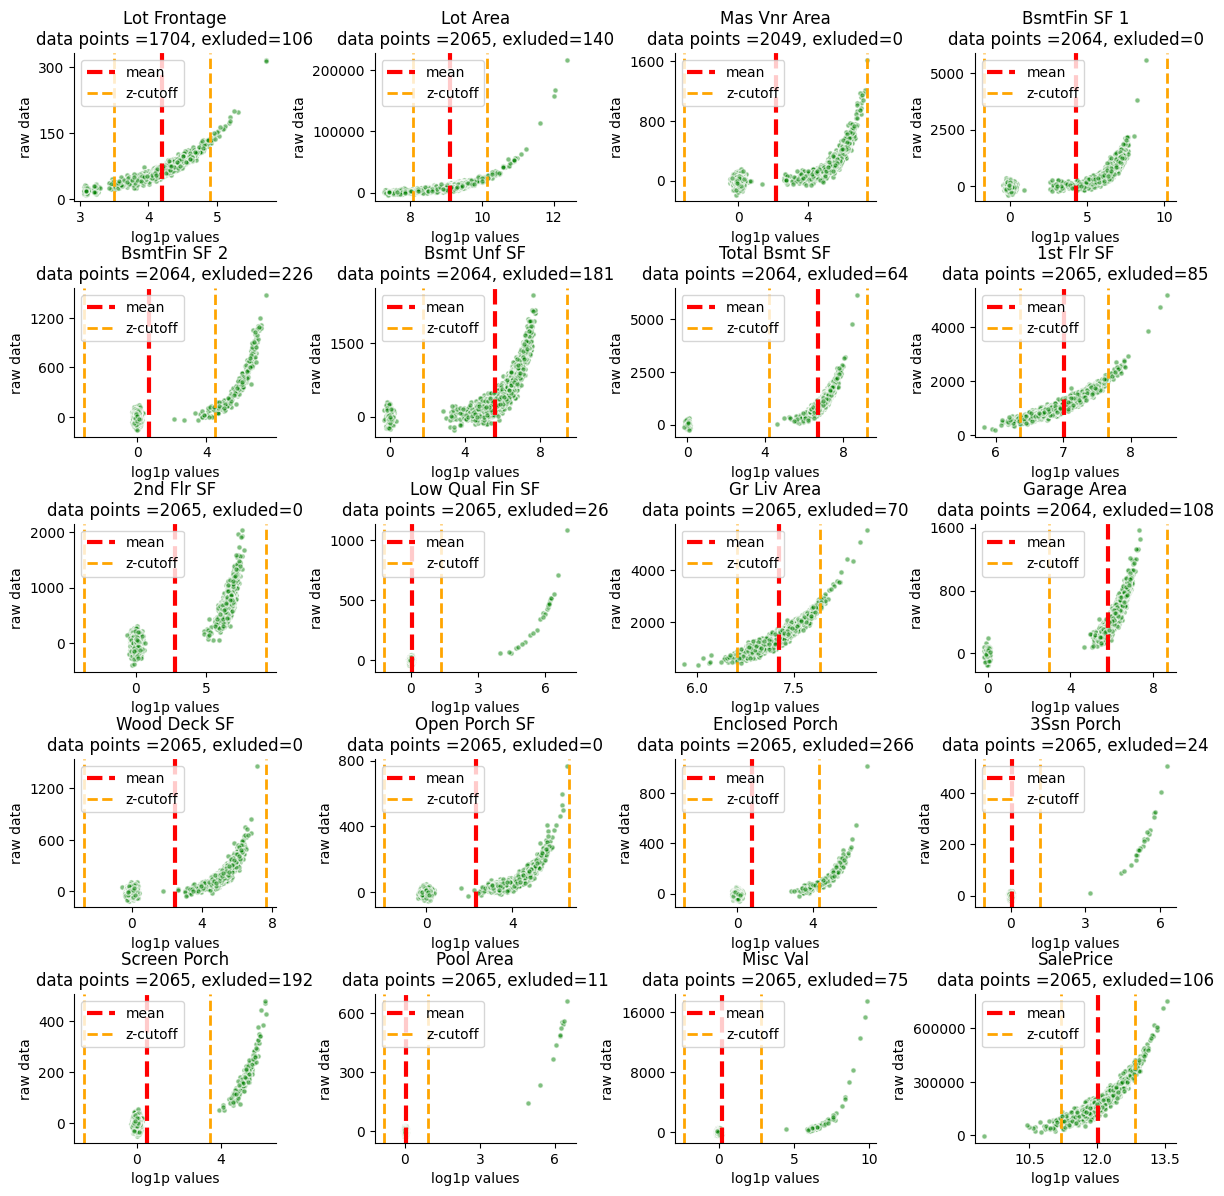

In [9]:
#plot scatter with z-score thresholds, 
test_outlier_removal_with_zscore(
    data_df = data_df.loc[:,CONTINUOUS_FEATURES],
    names = CONTINUOUS_FEATURES,
    zscore_cutoff=2,# YOU MAY TRY DIFFERENT Z-SCORES HERE !
    include_zeros=True, 
    add_noise = True, # if True, random noise is added to each variable, that helps visualizing each group
    )

### __CHECK FOR CORRELATIONS__

COMMENT
in case you are interested how weel the values correlate, create pairplot

    '''
                >>> sns.pairplot(   
                ...      data_df.loc[:,CONTINUOUS_FEATURES],   
                ...      x_vars=CONTINUOUS_FEATURES,   
                ...      y_vars=CONTINUOUS_FEATURES   
                ...     )   
                >>> plt.show()   
     '''

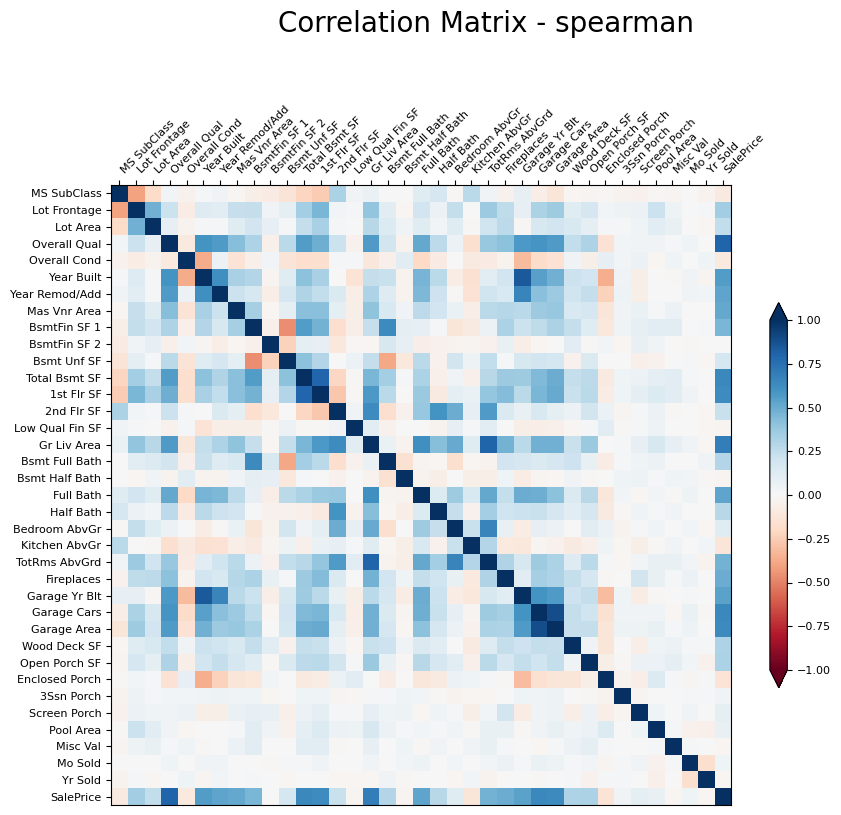

In [10]:
# plot heatmap
corr_heatmap(df=data_df, method='spearman')

In [11]:
# print pairs of variable with the highest corr. coef. 
corr_res = table_with_sorted_corr_results(data_df)  
display(corr_res.head())

,first,second,corr
0,Garage Area,Garage Cars,0.886189
1,Garage Yr Blt,Year Built,0.839975
2,Overall Qual,SalePrice,0.801359
3,Gr Liv Area,TotRms AbvGrd,0.797360
4,1st Flr SF,Total Bsmt SF,0.791462


In [12]:
# show potential "best" predictors for SalePrice
target_variable = "SalePrice"
display(corr_res.loc[corr_res.first==target_variable or corr_res.second==target_variable].head())

,first,second,corr
2,Overall Qual,SalePrice,0.801359
5,Gr Liv Area,SalePrice,0.690676
8,Garage Cars,SalePrice,0.645935
11,Garage Area,SalePrice,0.634693
12,1st Flr SF,SalePrice,0.630051


## __OBSERVATIONS & TAKE-AWAYS__

__OBSERVATIONS__
* the distibusion of most of numerical variables is strongly skewed, but it can be improved applying log1p tranformation before scaling. 
* Most variables, have large number of zero values, that could be intepreted as NaN or Absent/Present with binary transformer,
* the outliers, are not easy to separate with z-score, and shodul be kept in the data

__TAKE-AWAYS__
* apply log1p tranformation to all continuous variables, including target variable Sale Price. Subsequently, scale continuous variables,  
* use regression models, that may adjust for possible outliers in the data, such as hubert regression, 



## __EXAMINE CATEGORICAL VARIABLES IN MORE DETAIL__
---

### __IDENTIFY CATEGORICAL VARIABLES WITH DUPLICATED INFORMATION__
First, we will try to identify potential duplicates in text data using similarity index between pair of columns wiht categorical data.

__METHODS__  
I implemented modified jaccard similarity index, to asses the similarity in distriusion of classes in every pair combinaiton of features, that can be done in similar way as we use correlation to compare trends in numerical features.The function perfomrs pari-wise comparison of all or selected columns in df with any dtype (text, dattime and numeric), and returns similarity index for each comparison (0, 1], where:  
* ~0: Classes in two columns are perfectly mixed with each other,   
* 1: Two features have the same distribusion of classes, eg: you may get this result when coparing a data frame with a list of words in english and french, translations in two columns.
* Caution: features with large amount of misisng data, or only 1 class may gave high SI values.

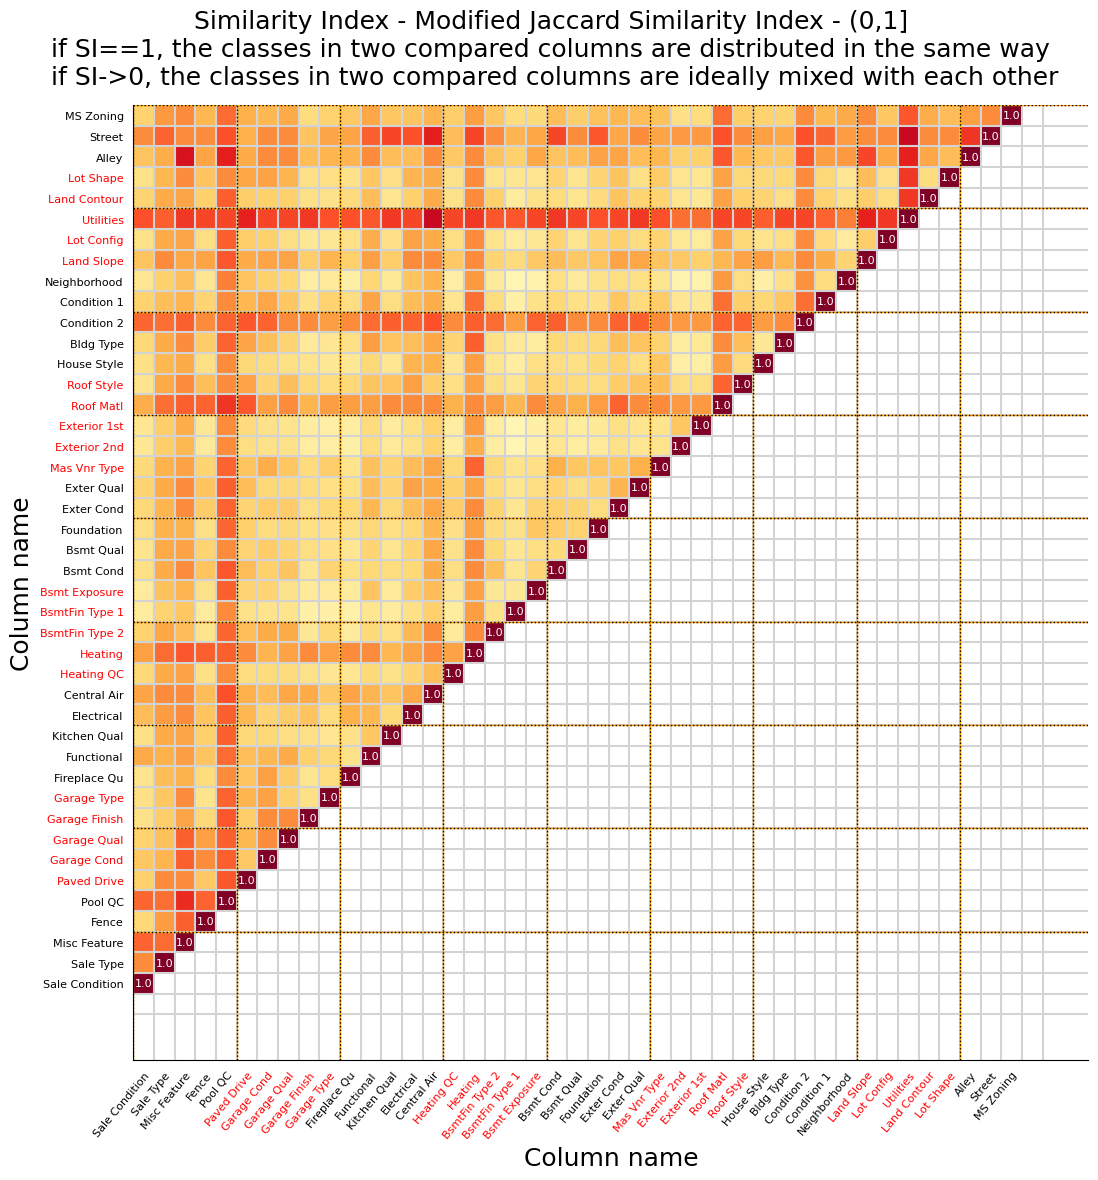

In [13]:
# Prepare the summary data so the next function may work (Function in Helpers)
data_examples, _, _ = dfe.summarize_df(  
    df = data_df, 
    nr_of_examples_per_category = 3,
    csv_file_name = None, # ie. no reports will be created 
    save_dir = None,      # as in the above
    verbose=False         
)

# calculate pair-wise similarity index 
cv_results_text = calculate_si(
    df=data_df, 
    df_ex=data_examples, 
    groups_to_display="text", 
    df_row_perc=25, # % of examples from each rows used
) 

# plot heatmap with similarity index 
si_heatmap(df=cv_results_text, fig_size=(12,12), title_fontsize=18);

In [14]:
# Show table with Pairs of Columns with the highest similarity Index + their examples
topSI_examples_text = order_si_table(
    df_summary= data_examples, 
    df_cv_results=cv_results_text, 
    SI_threshold=0.6
)

topSI_examples_text.iloc[0:10,0:5]

,attribute 1,attribute 2,similarity index,examples attribute 1,examples attribute 2
0,Utilities,Central Air,0.833333,"8 ('99.9%', 'AllPub');('0.1%', 'NoSewr');('...","40 ('93.2%', 'Y');('6.8%', 'N') Name: examp..."
1,Street,Utilities,0.833333,"4 ('99.5%', 'Pave');('0.5%', 'Grvl') Name: ...","8 ('99.9%', 'AllPub');('0.1%', 'NoSewr');('..."
2,Alley,Misc Feature,0.783333,"5 ('61.9%', 'Grvl');('38.1%', 'Pave') Name:...","73 ('89.5%', 'Shed');('5.3%', 'Gar2');('2.6..."
3,Street,Central Air,0.740741,"4 ('99.5%', 'Pave');('0.5%', 'Grvl') Name: ...","40 ('93.2%', 'Y');('6.8%', 'N') Name: examp..."
4,Alley,Pool QC,0.739583,"5 ('61.9%', 'Grvl');('38.1%', 'Pave') Name:...","71 ('36.4%', 'Ex');('27.3%', 'TA');('18.2%'..."
5,Utilities,Land Slope,0.733333,"8 ('99.9%', 'AllPub');('0.1%', 'NoSewr');('...","10 ('95.1%', 'Gtl');('4.3%', 'Mod');('0.7%'..."
6,Utilities,Paved Drive,0.733333,"8 ('99.9%', 'AllPub');('0.1%', 'NoSewr');('...","64 ('90.5%', 'Y');('7.3%', 'N');('2.3%', 'P..."
7,Alley,Utilities,0.733333,"5 ('61.9%', 'Grvl');('38.1%', 'Pave') Name:...","8 ('99.9%', 'AllPub');('0.1%', 'NoSewr');('..."
8,Pool QC,Misc Feature,0.708333,"71 ('36.4%', 'Ex');('27.3%', 'TA');('18.2%'...","73 ('89.5%', 'Shed');('5.3%', 'Gar2');('2.6..."
9,Roof Matl,Pool QC,0.683594,"21 ('98.3%', 'CompShg');('1.0%', 'Tar&Grv')...","71 ('36.4%', 'Ex');('27.3%', 'TA');('18.2%'..."



__OBSERVATIONS__
* There are no obvoius pairs of columns with duplicated information 
*  However, distribusion of classes in Utilities, is similar to ditribusion of classes in large number of the other features, with the strongest similarity, to "Alley", and "Land Slope"  

__ACTIONS__
* I will use all categorical columns to build the initial model,
* I will test if we can stratify numerical and response variable with categorical features that showed the highest class distribusion similarity to many other features, eg: Utilities.

### __CHECK HOW CLASSES IN INDICATOR VARIABLES ARE CORRELATED WITH THE TARGET VARIABLE__

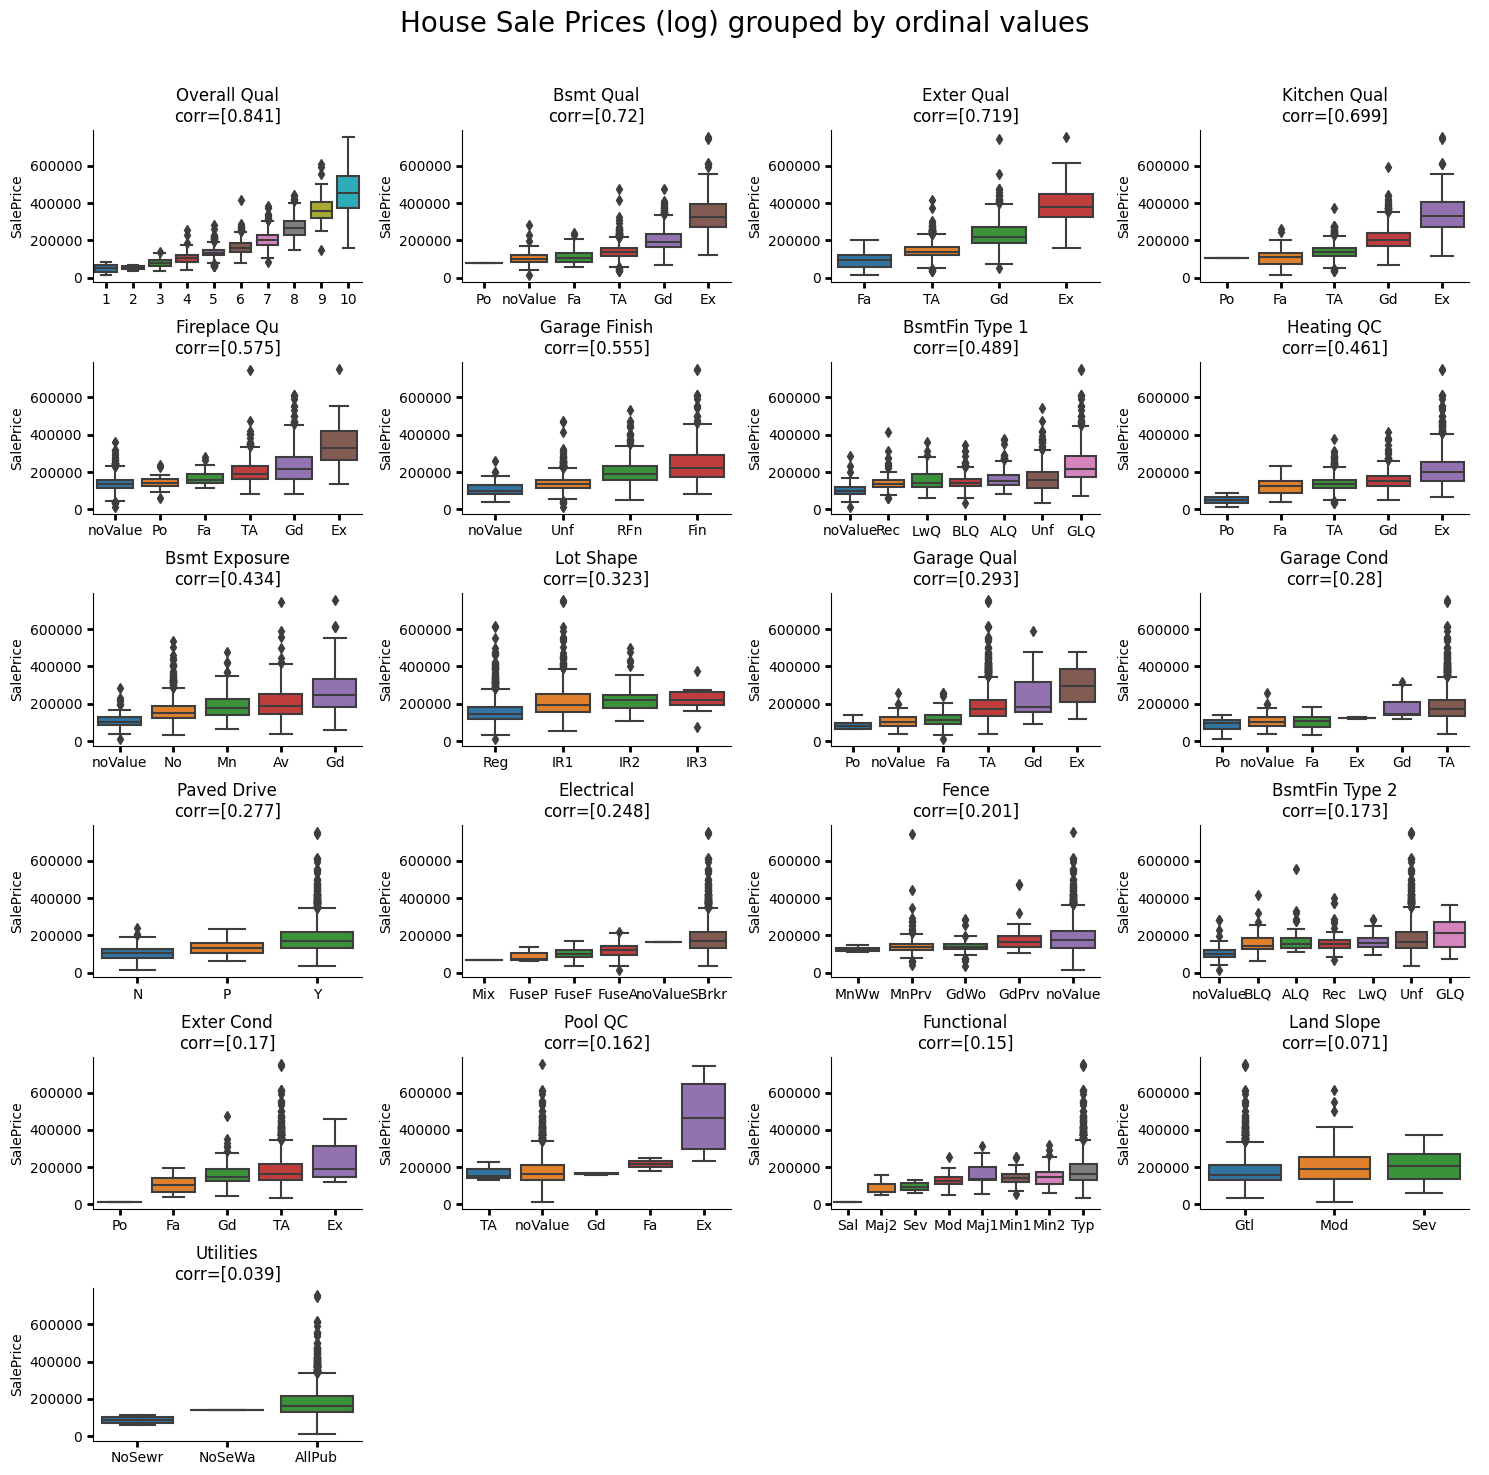

In [15]:
# select variables, for boxplots
#ordinal_variables_dct = ORDINAL_VARIABLES_WITH_VALUES
ordinal_colNames = list(ORDINAL_VARIABLES_WITH_VALUES.keys()).copy()
all_colNames = ordinal_colNames.copy()
all_colNames.append("SalePrice")

# create df for boxplot
data_for_boxplot = data_df.loc[:,all_colNames]
data_for_boxplot.head()

# replace missing data
for i,col in enumerate(ordinal_colNames):
    data_for_boxplot.loc[:,col].fillna("noValue", inplace=True)

# add log1p of SalePrice
data_for_boxplot["SalePriceLog"] = np.log1p(data_for_boxplot.SalePrice.values)

# test
data_for_boxplot.head()

# plot boxplots
ordered_boxplots(
    title="House Sale Prices (log) grouped by ordinal values",
    df=data_for_boxplot,
    yvar="SalePrice", 
    axvars=ordinal_colNames
)

### TAKE-AWYAS
* you can use mean or median (both were tested) to automatically assign numbers to each class
* the following ordinal variables shodul be tranfomed only into dummy variables,
    * {"Lot Shape", "Utilities", "Land Slope", "BsmtFin Type 1", "BsmtFin Type 2", "Pool QC", "Fence"}

## __CHECK IF SOME OF THE CATEGORICAL VARIABLES MAY BE USED TO CLUSTER NUMERICAL VARIABLES & BUILD SEPARATE MODELS__

__METHODS__

DONE IN THREE STEPS.
* __First__, I will bucketize all numerical variables, with sklearn KBinsDiscretizer, and impute missing data, 
with SimpleImputer. I will create preprocessing pipeline with ColumnTransformer, to treat numerical and non-numerical variables separately, 
* __Secondly__, I will select categorical variables, that have high similarity index with the numerical variables, 
that may
* __Finaly__, I will project numerical variables, on principial axes wiht PCA analysis, and plot, the points, classified with the categorical variables, selected in the second step. in case of seprate sources of the data, the classes shdoul be separated from each other on the plots. 

### __STEP 1. Prepare Numerical & Categorical Data__
First we will prepare numerical data, and inpute missing data, in each variable. Subsequently, we will bucketize he numerical values, in order to allow, class distribusion comparison between categorical and numerical variables


In [16]:
# create data preprocessor for numeric features
numeric_features = CONTINUOUS_FEATURES.copy()
numeric_transformer = Pipeline(steps=[
        ("imputer",SimpleImputer(strategy='most_frequent')),
        ("discretizer",KBinsDiscretizer(n_bins=10, encode='ordinal'))
    ])

# create data preprocessor for all other features
all_other_features = data_df.columns.values.tolist()
for v in numeric_features:
    try:
        all_other_features.remove(v)
    except:
        pass
all_other_transformer = Pipeline(steps=[
        ("imputer",SimpleImputer(strategy='most_frequent'))
    ])        

# preprocessor for all the data
preprocessor = make_pipeline(
    ColumnTransformer(
        transformers = [
            ("numeric_features", numeric_transformer, numeric_features),
            ("other_data_types", all_other_transformer, all_other_features)
        ])
    )

# check if everythign is ok
set_config(display="diagram") # or "text"
preprocessor

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric_features',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('discretizer',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=10))]),
                                                  ['Lot Frontage', 'Lot Area',
                                                   'Mas Vnr Area',
                                                   'BsmtFin SF 1',
                                                   'BsmtFin SF 2',
                                                   'Bsmt Unf SF',
                                                   'Total Bsmt SF',
                                                   '1st Flr SF', '2nd Flr SF',
                                                   'Low Qual Fin SF',
                                                   'Gr...
                                                   'Street', 'Alley',
                                                   'Lot Shape', 'Land Contour',
                                                   'Utilities', 'Lot Config',
                                                   'Land Slope', 'Neighborhood',
                                                   'Condition 1', 'Condition 2',
                                                   'Bldg Type', 'House Style',
                                                   'Overall Qual',
                                                   'Overall Cond', 'Year Built',
                                                   'Year Remod/Add',
                                                   'Roof Style', 'Roof Matl',
                                                   'Exterior 1st',
                                                   'Exterior 2nd',
                                                   'Mas Vnr Type', 'Exter Qual',
                                                   'Exter Cond', 'Foundation',
                                                   'Bsmt Qual', 'Bsmt Cond',
                                                   'Bsmt Exposure',
                                                   'BsmtFin Type 1', ...])]))])

In [17]:
# import warnings
''' tranformation, may generate warnigns, if the bucket number was > then the 
    number of classes in the feature,  the umber is beign corrected automatically'''
warnings.filterwarnings("ignore")

# prepare the data with preprocessor
prepared_data = preprocessor.fit_transform(data_df)

# add column names in correct order
numeric_features.extend(all_other_features)
tranformed_df = pd.DataFrame(prepared_data, columns=numeric_features)

# test
tranformed_df.head() 

,Lot Frontage,Lot Area,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,...,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence,Misc Feature,Mo Sold,Yr Sold,Sale Type,Sale Condition
0,7.0,8.0,0.0,0.0,1.0,0.0,5.0,4.0,0.0,0.0,...,TA,TA,Y,Ex,MnPrv,Shed,11,2006,WD,Normal
1,4.0,3.0,0.0,0.0,0.0,7.0,2.0,1.0,3.0,0.0,...,TA,TA,Y,Ex,MnPrv,Shed,8,2006,New,Partial
2,3.0,5.0,3.0,1.0,0.0,8.0,6.0,6.0,1.0,0.0,...,TA,TA,Y,Ex,MnPrv,Shed,5,2006,WD,Normal
3,3.0,5.0,0.0,0.0,0.0,8.0,4.0,3.0,2.0,0.0,...,TA,TA,Y,Ex,MnPrv,Shed,4,2010,WD,Abnorml
4,3.0,8.0,0.0,5.0,0.0,3.0,7.0,7.0,0.0,0.0,...,TA,TA,Y,Ex,GdPrv,Shed,6,2008,WD,Normal


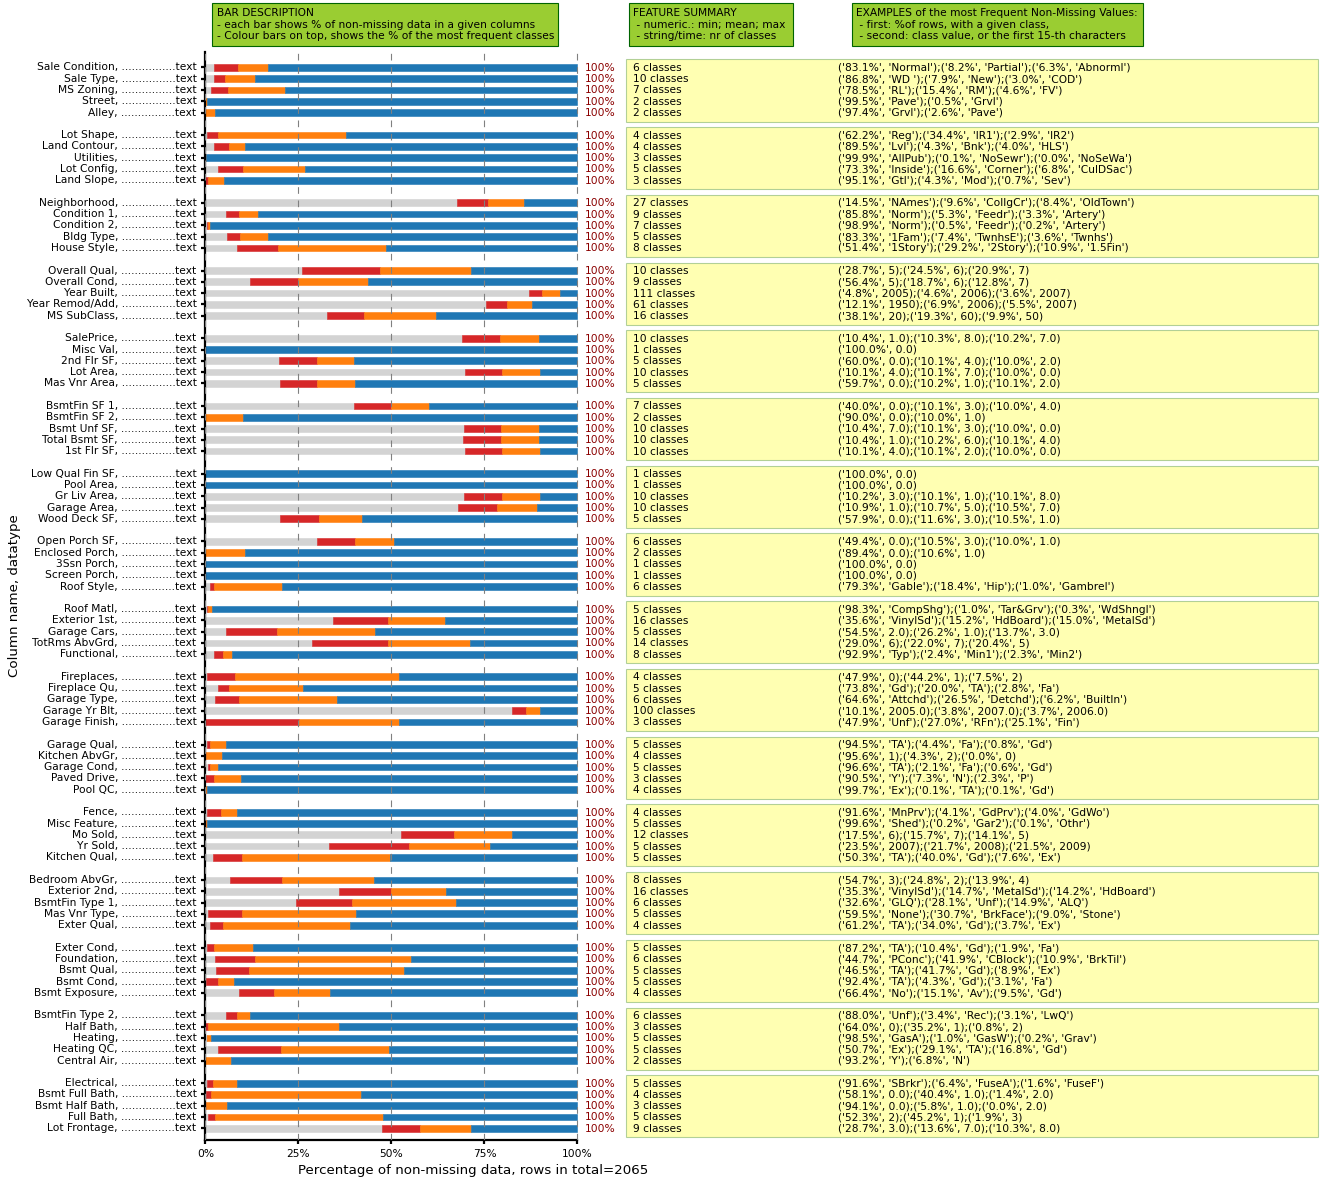

In [18]:
# test data tranformation
'''all variables shoudl be text-type, and without missing data'''
dfe.df_summary_plot(
    df                  = tranformed_df,
    barPlot_figsize     = (18,16),
    showTable           = False,
    pieChart            = False,
    barPlot_dct         = df_summary_plot__barPlot_dct, # dict with configs
) 

### STEP 2. Select categorical variables that affect the most feature space of numerical variables.
we will use the same method as with detecting duplicates in text data, ie. I will calulate similarity index between each pair of 


In [19]:
# get examples from each feature
data_examples, _, _ = dfe.summarize_df(df = tranformed_df)

# calculate pair-wise similarity index 
cv_results_text = calculate_si(
    df=tranformed_df, 
    df_ex=data_examples, 
    groups_to_display="all", #"text", 
    df_row_perc=10, # % of examples from each rows used
) 

# plot heatmap with similarity index 
'''try me:) - I preffer the table with large number of comparisons'''
# si_heatmap(df=cv_results_text, fig_size=(20, 20), title_fontsize=18);

# collect examples for the table,
topSI_examples_text = order_si_table(
    df_summary= data_examples, 
    df_cv_results=cv_results_text, 
    SI_threshold=0.6
)

# remove, faulty examples created with features that have only one class, 
idx = topSI_examples_text.loc[:,'examples attribute 1'].astype("str").str.contains(pat="100.0").values
idx[topSI_examples_text.loc[:,'examples attribute 2'].astype("str").str.contains(pat="100.0").values==True]=True

# 
topSI_examples_text.loc[idx!=True,:]

,attribute 1,attribute 2,similarity index,examples attribute 1,examples attribute 2
8,Street,Utilities,1.000000,"22 ('99.5%', 'Pave');('0.5%', 'Grvl') Name:...","26 ('99.9%', 'AllPub');('0.1%', 'NoSewr');(..."
14,Utilities,Misc Feature,1.000000,"26 ('99.9%', 'AllPub');('0.1%', 'NoSewr');(...","75 ('99.6%', 'Shed');('0.2%', 'Gar2');('0.1..."
26,Street,Misc Feature,1.000000,"22 ('99.5%', 'Pave');('0.5%', 'Grvl') Name:...","75 ('99.6%', 'Shed');('0.2%', 'Gar2');('0.1..."
28,Roof Style,Roof Matl,0.885714,"38 ('79.3%', 'Gable');('18.4%', 'Hip');('1....","39 ('98.3%', 'CompShg');('1.0%', 'Tar&Grv')..."
29,Central Air,Misc Feature,0.833333,"53 ('93.2%', 'Y');('6.8%', 'N') Name: examp...","75 ('99.6%', 'Shed');('0.2%', 'Gar2');('0.1..."
...,...,...,...,...,...
481,Utilities,Yr Sold,0.644444,"26 ('99.9%', 'AllPub');('0.1%', 'NoSewr');(...","77 ('23.5%', 2007);('21.7%', 2008);('21.5%'..."
482,Utilities,Sale Condition,0.644444,"26 ('99.9%', 'AllPub');('0.1%', 'NoSewr');(...","79 ('83.1%', 'Normal');('8.2%', 'Partial');..."
483,Lot Config,Misc Feature,0.644444,"27 ('73.3%', 'Inside');('16.6%', 'Corner');...","75 ('99.6%', 'Shed');('0.2%', 'Gar2');('0.1..."
484,MS Zoning,Street,0.644444,"21 ('78.5%', 'RL');('15.4%', 'RM');('4.6%',...","22 ('99.5%', 'Pave');('0.5%', 'Grvl') Name:..."


__table description__
* SI_threshold - similarity Index threshold, 
* all pairs with SI>=Threshold will be shown in printed table
* TIPS:
    * kaggle provided description of each feature, with the datasets, in a file called documentation.txt/.csv
    * table has attribute examples, 
        -  show the number of all classes in the columns
        -  and in brackets, % of rows with a given example, and class values
        -  examples are sorted from the most frequent
        


__OBSERVATIONS__
 

__ACTIONS__


### STEP 3. CHECK FOR SEPARATE SOURCES IN THE DATA WITH PCA

I will project numerical variables, on principial axes wiht PCA analysis, and plot, the points, classified with the categorical variables, selected in the second step. in case of seprate sources of the data, the classes shdoul be separated from each other on the plots. 

In [20]:
# pca n_components
n = 10

# prepare numerical data for pca
cf = CONTINUOUS_FEATURES.copy()
#cf.remove('SalePrice')
num_df = data_df.loc[:, cf]
num_arr = num_df.values

# create custom transformer
log1p_scale_transformer = make_pipeline( 
  		FunctionTransformer(np.log1p, validate=False),
 	 	StandardScaler()
 		)

# create data preprocessor
pca_preprocessor = Pipeline(steps=[
        ("imputer",SimpleImputer(strategy='most_frequent')),
        ("log1p",log1p_scale_transformer),
        ("pca",PCA(n_components=n))
        ]
)

# Step 4. Project data onto the first two components
pca_results = pca_preprocessor.fit_transform(num_arr)
print(pca_results.shape)

(2065, 10)


### plot figures wiht data projected on the first two components, and points classified with selected categorical features

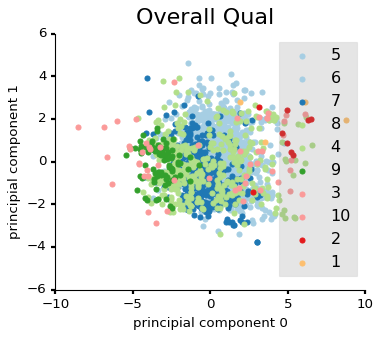

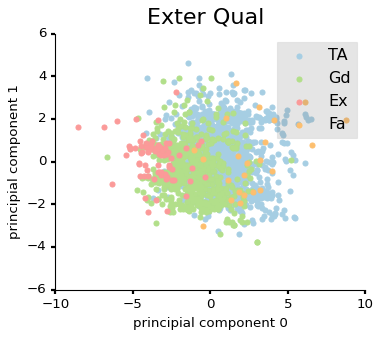

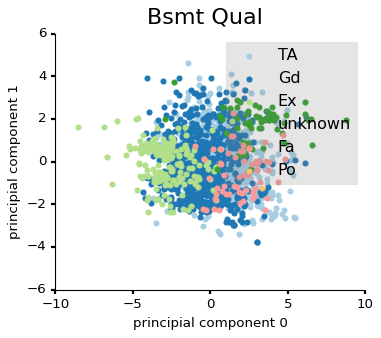

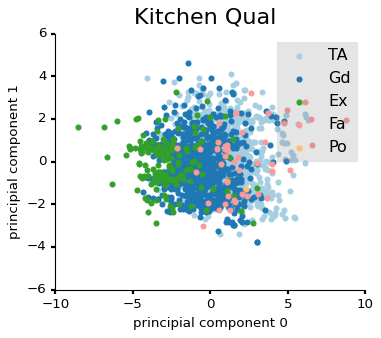

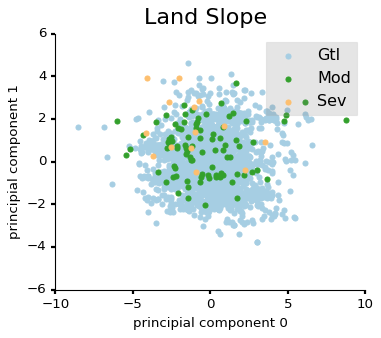

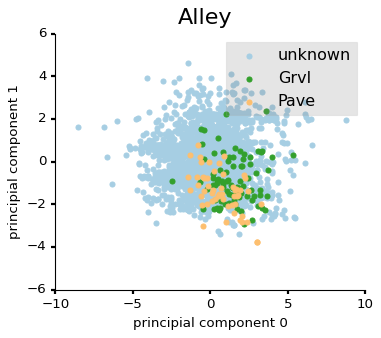

In [23]:
# select features to use for data segmentation
selected_class_indicators = ["Overall Qual", "Exter Qual","Bsmt Qual","Kitchen Qual","Land Slope", "Alley"]

# plots
plot_pca_resutls(
    pca_results = pca_results, 
    indicators_df = data_df, 
    indicators = selected_class_indicators)